In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# Load, Transform, and Explore the Dataset

In [2]:
DATA_FILE = 'time_series_covid19_confirmed_global.csv'
def load_data():
    """
    Load data from a source and perform data preprocessing.

    Returns:
    DataFrame: Processed DataFrame with top 5 countries based on cumulative cases.
    """

    # =============================================================================
    # Step 1: Data Loading
    # =============================================================================
    
    # Load data from a source (assuming df is your DataFrame)
    df = pd.read_csv(DATA_FILE)

    # =============================================================================
    # Step 2: Data Preprocessing
    # =============================================================================

    # Drop unnecessary columns
    df.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)

    # Group by 'Country/Region' column and aggregate corresponding values
    df_grouped = df.groupby('Country/Region').agg('sum').reset_index()

    # =============================================================================
    # Step 3: Reshaping DataFrame
    # =============================================================================

    # Transpose DataFrame
    df_transposed = df_grouped.transpose()
    df_transposed.reset_index(inplace=True)

    # Reset index and set the first row as column names
    df_transposed.columns = df_transposed.iloc[0]
    df_transposed.drop(df_transposed.index[0], inplace=True)

    # Rename columns
    df_transposed.rename(columns={'Country/Region': 'Date'}, inplace=True)

    # Reset index to DateTimeIndex
    df_transposed['Date'] = pd.to_datetime(df_transposed['Date'])
    df_transposed.set_index('Date', inplace=True)

    # =============================================================================
    # Step 4: Determining Top 5 Countries
    # =============================================================================

    # Calculate the sum of each column
    column_sums = df_transposed.sum()

    # Sort the sums in descending order and select the top 5 column names
    top_5_columns = column_sums.sort_values(ascending=False).head(5).index

    # Filter the DataFrame to keep only the top 5 columns
    df_top_5 = df_transposed[top_5_columns]

    return df_top_5


In [3]:
df_top_5 = load_data()
df_top_5.head()

,US,India,Brazil,France,Germany
Date,,,,,
2020-01-22,1,0,0,0,0
2020-01-23,1,0,0,0,0
2020-01-24,2,0,0,2,0
2020-01-25,2,0,0,3,0
2020-01-26,5,0,0,3,0


In [4]:
import matplotlib.pyplot as plt

def plot_daily_cases(df_top_5):
    """
    Plot daily cases for each country in the top 5 for most cumulative cases.

    Args:
    df_top_5 (DataFrame): DataFrame containing data for top 5 countries based on cumulative cases.
    """

    # Plot each country's daily cases
    for country in df_top_5.columns:
        plt.plot(df_top_5.index, df_top_5[country], label=country)

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Daily Cases')
    plt.title('Daily Cases for Top 5 Countries with Most Cumulative Cases')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

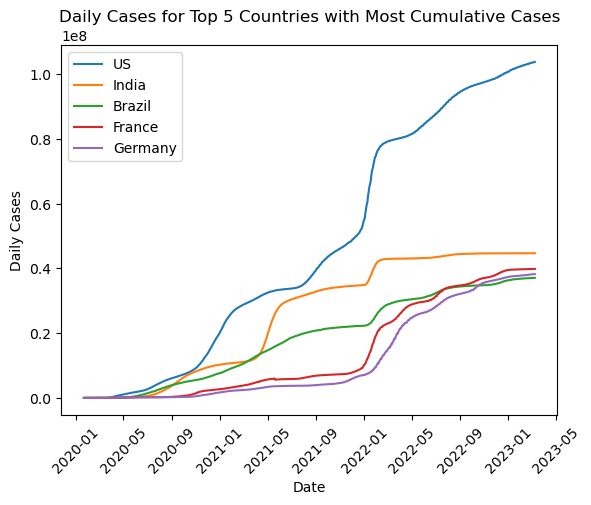

In [5]:
# Plot daily cases for top 5 countries
plot_daily_cases(df_top_5)